# <center> Introduction </center>

Markov chain Monte Carlo (MCMC) methods are a class of algorithms for sampling from a probability distribution based on constructing a Markov chain that has the desired distribution of its equilibrium distribution. 
It is very handy to simulate posterior distribution where often the density function is known only up to a constant scaling factor.  



### 1. Inverse CDF Method

When a cumulative distribution function (CDF) has closed-form inverse function, this method can be conveniently used to produce random variables with such distribution, from uniform random variables.
The inverse function of a CDF is its quantile function, so this method can also be called quantile sampling method.

In this method, we draw a realization $\alpha$ from the standard uniform distribution $U(0,1)$, and use the $\alpha$-quantile of the desired distribution as its realization.

This process can be illustrated by the following plot:

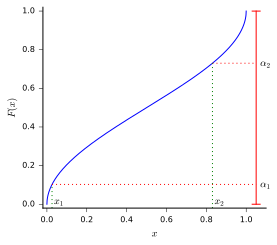

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
from scipy.special import btdtr, btdtri
xs = np.linspace(0, 1, 1000)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(4, 3.6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim([-0.02, 1.1])
ax.set_ylim([-0.02, 1.02])
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.plot(xs, btdtr(0.5, 0.5, xs))
ax.plot([1.03, 1.07],[0.0, 0.0],'r')
ax.plot([1.03, 1.07],[1.0, 1.0],'r')
ax.plot([1.05, 1.05],[0.0, 1.0],'r')

U = np.random.rand(2)
i = 1
for u in U:
    x = btdtri(0.5, 0.5, u)
    ax.text(1.07, u, '$\\alpha_'+str(i)+'$', verticalalignment='center' )
    ax.plot([x, 1.05], [u, u], ':r')
    ax.text(x+0.01, -0.01, '$x_'+str(i)+'$', verticalalignment='bottom')
    ax.plot([x, x], [-0.02, u], ':g')
    i += 1
ax.tick_params(axis='both', which='major', direction='out', labelsize=8)
ax.set_xlabel('$x$')
ax.set_ylabel('$F(x)$')
#fig.savefig('resource/InverseCDF.svg')    

As we can see from the above figure, $\alpha_1$ and $\alpha_2$ are sampled from standard uniform distribution,
and the corresponding $x_1$ and $x_2$ are the realizations with desired distribution $F(x)$.

Why does this work? Let's denote $F_X$ as the CDF of $X$, $F^{-1}_X$ as the quantile function of $X$ and $U$ as a standard uniform random variable. The inverse CDF method is effectively sampling $X$ with $F_X^{-1}(U)$, and we will hope to believe is that $F_X^{-1}(U)$ and $X$ have the same distribution.
Namely, let's define a new random variable $Y = F_X^{-1}(U)$ and its CDF as $G$, what we want to prove is:

$$G\left(x\right)=F_{X}\left(x\right)$$

The proof can be obtained by definition and properties of CDF, 

\begin{align*}
G(x) & =P(Y<x)\\
 & =P\left(F_{X}^{-1}\left(U\right)<x\right)\\
\mbox{} & =P\left(F_{X}F_{X}^{-1}\left(U\right)<F_{X}\left(x\right)\right)\quad\mathrm{monotonicity\ of\ cdf}\\
 & =P\left(U<F_{X}\left(x\right)\right)\\
 & =F_{X}\left(x\right)\quad\mathrm{property\ of\ standard\ uniform\ distribution}
\end{align*}

Let's define two random variables as equivalent if they have the same distribution, and denote this relation as: $X \sim Y$.
We just proved that:

$$F_{X}^{-1}\left(U\right)\sim X$$

A function of two equivalent random variables should also have the same distribution, and thus equivalent. 
By applying the function $F_X$ to both two random variables both, we have this interesting property:

$$F_{X}\left(X\right)\sim U$$

Since $F_X$ and $F_X^{-1}$ are invertible, we have:

$$F_{X}\left(X\right)\sim U\iff F_{X}^{-1}\left(U\right)\sim X$$

We can also prove the left hand side to obtain the right hand side for free:

\begin{align*}
P\left(F_{X}\left(X\right)<\alpha\right) & =P\left(F_{X}^{-1}F_{X}\left(X\right)<F_{X}^{-1}\left(\alpha\right)\right)\\
 & =P\left(X<F_{X}^{-1}\left(\alpha\right)\right)\\
 & =F_{X}\left(F_{X}^{-1}\left(\alpha\right)\right)\\
 & =\alpha\\
\iff F_{X}\left(X\right) & \sim U
\end{align*}

The left hand side we just proved give us a way to sample uniform distribution from any distribution that we are able to sample and know its CDF.
Together with the inverse CDF method, we can sample any single random variable whose quantile function is available, if we can sample at least one distribution with known distribution function:

$$X\sim F_{X}^{-1}\left(F_{Y}\left(Y\right)\right)$$

In the above case, we know the CDF of $Y$, and know how to sample it. If we know the quantile function of $X$, then we are able to sample $X$ using $Y$.

What if the quantile function is not available or too computationally prohibitive? We can still use inverse CDF method if only the CDF is available, because evaluating the inverse of a function is equivalent to the finding the root of the original function. In this case the inverse CDF method can be formulated as:

\begin{align*}
\mathrm{Find}\quad & x_{i}\\
\mathrm{such\ that}\quad & F_{X}\left(x_{i}\right)=\alpha_{i},\\
\mathrm{where}\quad & \alpha_{i}\sim U\left(0,1\right)
\end{align*}


### 2.  Acceptance/Rejection Method

Suppose we want to sample a random variable $X$ with know density function $f_X$, and we are already able to sample another random variable $Y$ with know density function $f_Y$.

If we are lucky enough to have measure $P\circ X^{-1}$ absolutely continuous w.r.t. $P\circ Y^{-1}$,
we should be able to characterize random variable $X$ by $Y$ with change of measure. Here the Radon-Nikodym derivative is:

$$\frac{\mathrm{d}\left(P\circ X^{-1}\right)}{\mathrm{d}\left(P\circ Y^{-1}\right)}=\frac{f_{X}}{f_{Y}}$$

The goal is to simulate the event $\{X<x\}$ following the CDF $F_X$, using samples from $Y$. Let's use change of measure to connect $X$ and $Y$:

\begin{align*}
P\left(X < x\right) & =\int_{-\infty}^{x}f_{X}\left(z\right)\mbox{d}z\\
 & =\int_{-\infty}^{x}f_{Y}\left(z\right)\cdot\frac{f_{X}\left(z\right)}{f_{Y}\left(z\right)}\mbox{d}z\\
 & =\int_{-\infty}^{+\infty}\frac{f_{X}\left(z\right)}{f_{Y}\left(z\right)}\cdot\mathbf{1}_{\{z < x\}}\cdot f_{Y}\left(z\right)\mbox{d}z
\end{align*}

If we consider $z$ as a realization of random variable $Y$,
the above integral can be interpreted as an expectation w.r.t. $Y$:

$$\mathbb{E}_{Y}\left[\frac{f_{X}\left(Y\right)}{f_{Y}\left(Y\right)}\cdot\mathbf{1}_{\left\{ Y < x\right\} }\right]$$

We wish to construct certain event, because algorithm itself is a sequence of action based on events.

Suppose we can find constant $c>0$ such that:

$$\frac{f_{X}}{cf_{Y}}\le1$$
always holds.

We also have, for a standard uniform random variable $U$:

\begin{align*}
P\left(U < \frac{f_{X}}{cf_{Y}}\right) & =\frac{f_{X}}{cf_{Y}}
\end{align*}

With the creatively introduced uniform random variable $U$ and the event $\{U < \frac{f_{X}\left(Y\right)}{cf_{Y}\left(Y\right)}\}$, we have:

\begin{align*}
P\left(X < x\right) & =\mathbb{E}_{Y}\left[\frac{f_{X}\left(Y\right)}{f_{Y}\left(Y\right)}\cdot\mathbf{1}_{\left\{ Y < x\right\} }\right]\\
 & =c\cdot\mathbb{E}_{Y}\left[P\left(U<\frac{f_{X}\left(Y\right)}{cf_{Y}\left(Y\right)}\right)\cdot\mathbf{1}_{\left\{ Y<x\right\} }\right]\\
 & = c\cdot\mathbb{E}_{Y}\left[\mathbb{E}_{U}\left[\mathbf{1}_{\{U <\frac{f_{X}\left(Y\right)}{cf_{Y}\left(Y\right)}\}}\right]\cdot\mathbf{1}_{\left\{ Y <x\right\} }\right]\\
 & = c\cdot\mathbb{E}_{Y,U}\left[\mathbf{1}_{\{U<\frac{f_{X}\left(Y\right)}{cf_{Y}\left(Y\right)}\}}\cdot\mathbf{1}_{\left\{ Y<x\right\} }\right]\quad\mathrm{Fubini's\ theorem}\\
 & =c\cdot P\left(U<\frac{f_{X}\left(Y\right)}{cf_{Y}\left(Y\right)},Y<x\right)\\
 & =c\cdot P\left(Y<x\left|U<\frac{f_{X}\left(Y\right)}{cf_{Y}\left(Y\right)}\right.\right)\cdot P\left(U<\frac{f_{X}\left(Y\right)}{cf_{Y}\left(Y\right)}\right)\\
 & =c\cdot P\left(Y<x\left|U<\frac{f_{X}\left(Y\right)}{cf_{Y}\left(Y\right)}\right.\right)\cdot\mathbb{E}_{Y}\left[P\left(\left.U<\frac{f_{X}\left(Y\right)}{cf_{Y}\left(Y\right)}\right|Y\right)\right]\\
 & =c\cdot P\left(Y<x\left|U<\frac{f_{X}\left(Y\right)}{cf_{Y}\left(Y\right)}\right.\right)\cdot\mathbb{E}_{Y}\left[\frac{f_{X}\left(Y\right)}{cf_{Y}\left(Y\right)}\right]\\
 & =P\left(Y<x\left|U<\frac{f_{X}\left(Y\right)}{cf_{Y}\left(Y\right)}\right.\right)\cdot\mathbb{E}_{Y}\left[\frac{f_{X}\left(Y\right)}{f_{Y}\left(Y\right)}\right]\\
 & =P\left(Y<x\left|U<\frac{f_{X}\left(Y\right)}{cf_{Y}\left(Y\right)}\right.\right)
\end{align*}

The equality we proved here:

$$P\left(Y<x\left|U<\frac{f_{X}\left(Y\right)}{cf_{Y}\left(Y\right)}\right.\right)=P\left(X<x\right)$$

demonstrates that, if we sample random variable $Y$ with density function $f_Y$ 
and accept each of its realizations with a probability of $\frac{f_{X}\left(Y\right)}{cf_{Y}\left(Y\right)}$, 
the resulted realization will have distribution of $X$.
